# Self-Driving Car Engineer Nanodegree


## Project 2: **Advanced Lane Finding** 

The goals / steps of this project are the following:
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

The above steps can can be catogorized into two parts with the following structure

1. Off-line preparation
    - Camera calibration
- On-line processing/pipeline
    - Image preprocessing
        - Un-distort an image
        - Create a binary image marking possible lane pixels
        - Apply perspective transform to "birds-eye view"
    - Lane-finding algorithm
        - Detect lane pixels and fit to find the lane boundary
        - Determine the curvature of the lane and vehicle position with respect to center
    - Visualization
        - Warp the detected lane boundaries back onto the original image
        - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

This notebook will then follow the above structure.

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import glob
%matplotlib inline

# Part 1: Off-line Preparation

## Camera Calibration

The camera calibration step meants to find the intrinsic parameters and distortion coefficients of the camera we used. 
Because each camera is unique, and these parameters should be globally avelable for each camera, I create a class for cameras.

In [2]:
class CAMERA(object):
    """
    """
    def __init__(self):
        """
        """
        self.mtx = None
        self.dist = None
        
    def calibrate(self, image_name_list, board_size=(8,6)):
        """
        Inputs:
            - image_name_list: a list of image names
            - board_size: a touple of board size, like (8,6)
        Outputs:
            - True/False: True - finished, False - failed
        """
        objpoints = [] # 3D points in real-world coordinate
        imgpoints = [] # 2D points on 2D image plane
        
        # Prepare object points (of chessboard) in one image, like: [0,0,0], [1,0,0], [2,0,0], ..., [7,5,0]
        objp = np.zeros((board_size[0]*board_size[1], 3), np.float32)
        objp[:,:2] = np.mgrid[:board_size[0], :board_size[1]].T.reshape(-1,2) # Generate x,y coordinate and fill in the objp
        
        # Loop over images
        #--------------------------------------#
        gray = None
        for fname in image_name_list:
            # Read an image 
            img = cv2.imread(fname)
            
            # Convert the current image to grayscale
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            # Find chessboar corners
            ret, corners = cv2.findChessboardCorners(gray, board_size, None)

            # If objects are found, add object points and image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
        #--------------------------------------#
                
        # Calibrate camera
        #--------------------------------------#
        if gray is None:
            return False
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        self.mtx = mtx
        self.dist = dist
        #--------------------------------------#
        return True
    
    def undistort(self, img):
        """
        Input: 
            - Original image
        Output:
            - Un-distorted image
        """
        mtx = None
        return cv2.undistort(img, self.mtx, self.dist, None, mtx)


Now we create an instance for CAMERA (called **cam_1**) and calibrate it using the chessboard images in "camera_cal/"

In [3]:
# Create the camera object instance
cam_1 = CAMERA()

# Calibrate the camera
cal_images = glob.glob("camera_cal/calibration*.jpg")
# print("type(cal_images) = %s" % str(type(cal_images)))
# print("len(cal_images) = %d" % len(cal_images))
# print("cal_images = %s" % str(cal_images))
result = cam_1.calibrate(cal_images, (9,6))
print("Calibration finished!" if result else "Calibration failed!")

Calibration finished!


Processing image file calibration1.jpg


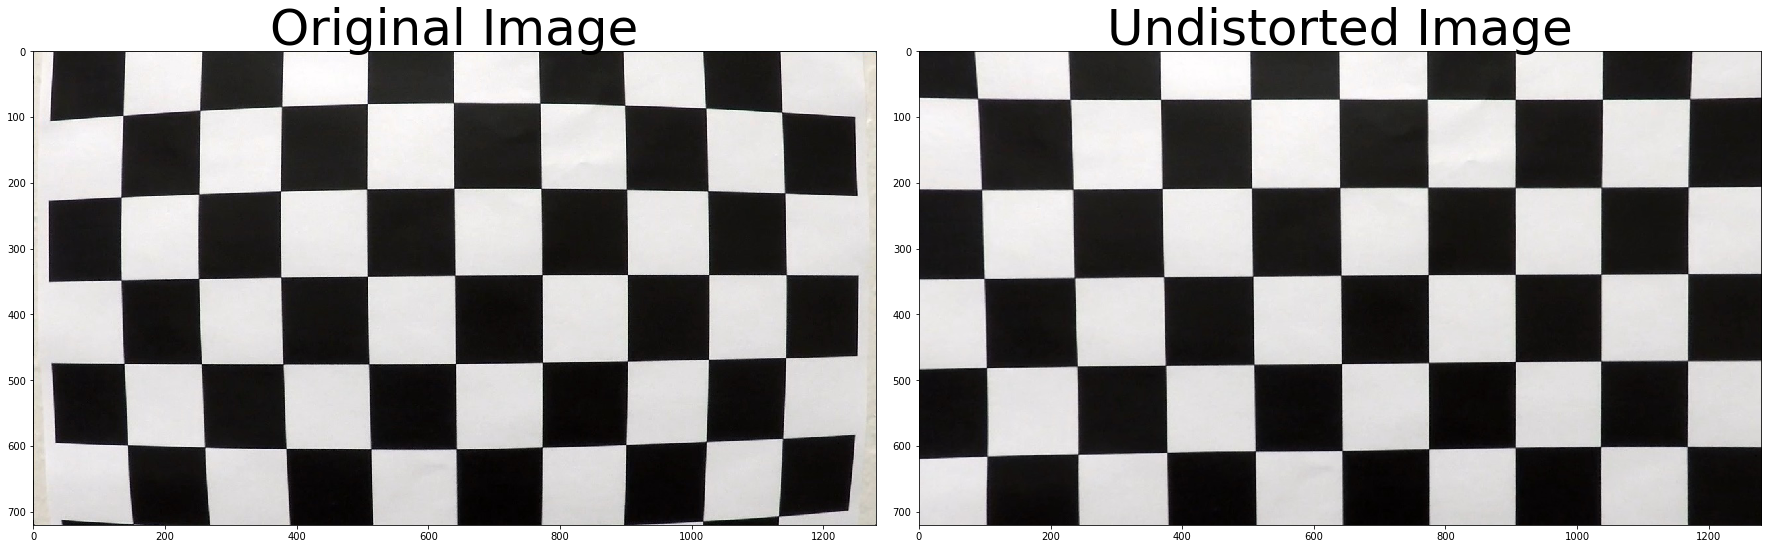

In [4]:
# Test the undistort() function
#-----------#
dir_in = "camera_cal/"
dir_out = "output_images/calibration/"
f_name = "calibration1.jpg"
print("Processing image file %s" % f_name)
img_ori = mpimg.imread(dir_in + f_name) # Read image from disk
img_undistorted = cam_1.undistort(img_ori)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_ori)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Save the result figure
plt.savefig(dir_out + "undistort_result.png")

---

# Part 2: On-line Processing and Pipeline

This part describe steps that will be executed for each image on-line.

## Image preprocessing

The goal of this process is to generate a binary image which is a bird-eye viewed image marked with lane-line points according to the input image.

There are thress steps:
- Un-distort an image
- Create a binary image marking possible lane pixels
- Apply perspective transform to "birds-eye view"

---

Before we continue, I create a function to help visualizing results and save results

In [5]:
def save_image_RGB_or_gray(img, dir_out, file_name_out):
    """
    """
    # Save images using cv2.imwrite(), which require BGR color layout rather than RGB
    if len(img.shape) > 2 and img.shape[2] == 3:
        img_BGR = cv2.cvtColor( img , cv2.COLOR_RGB2BGR)
    else:
        img_BGR = img
    cv2.imwrite(dir_out + file_name_out, img_BGR)
    
def save_image_BGR_or_gray(img, dir_out, file_name_out):
    """
    """
    # Save images using cv2.imwrite(), which require BGR color layout rather than RGB
    cv2.imwrite(dir_out + file_name_out, img)
    
def functional_test_of_image(dir_in, file_name_in, dir_out, function_to_test):
    """
    The function_to_test is the following function
        img_dict = function_to_test(img)
    where img is the input image, and img_dict is an output dictionary of image
    """
    # Process one image
    #-----------#
    # Read an image
    print("Processing image file %s" % file_name_in)
    img_ori = mpimg.imread(dir_in + file_name_in) # Read image from disk

    # The function to test
    img_dict = function_to_test(img_ori) 


    # Show all the intermediate images in pipeline
    #-------------------------------------------------#
    img_dict_key= list(img_dict.keys())
    print("img_dict_key = %s" % str(img_dict_key))
    fig_id = 0
    for fig_id in range(len(img_dict_key)):
        plt.figure(fig_id)
        plt.title("Fig. %d %s" % (fig_id, str(img_dict_key[fig_id])))
        plt.imshow(img_dict[img_dict_key[fig_id]], cmap='gray')
        # Save images using cv2.imwrite(), which require BGR color layout rather than RGB
        save_image_RGB_or_gray(img_dict[img_dict_key[fig_id]], dir_out, f_name[:-4] + "_" + img_dict_key[fig_id] + ".jpg" )

Images in the "test_images" directory

In [6]:
sorted(os.listdir("test_images/"))

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

Since there is a set of parameters shared with every input images, I create classes separately for each step.

---

### Step 1: Un-distort the input Image

This step is done by using the CAMERA.undistort() function, which is already implemented above.

---

### Step 2: Getting Binary Image of Lane-lines


In [7]:
class LANE_LINE_MASK(object):
    """
    """
    def __init__(self, prefix="biProc_"):
        """
        """
        # Parameters
        #-------------------------#
        self.blur_ker_size = 7
        self.mor_ker_size = 7 # 15 # 25
        #-------------------------#
        
        # Variables
        #-------------------------#
        self.prefix = prefix
        #-------------------------#
        
    # Morphological operation on color image
    def morphological_op_close(self, img, ker_size=3):
        """
        Morphological operations close
        """
        # Generate a rounded kernel 
        # kernel = np.ones((ker_size,ker_size), np.uint8) 
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(ker_size, ker_size))
        # 1. Closing operation for connecting islands
        return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    def morphological_op_open(self, img, ker_size=3):
        """
        Morphological operations open
        """
        # Generate a rounded kernel 
        # kernel = np.ones((ker_size,ker_size), np.uint8) 
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(ker_size, ker_size))
        # 1. Opening operation for connecting islands
        return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    
    def morphological_op_erode(self, img, ker_size=3):
        """
        Morphological operations erode
        """
        # Generate a rounded kernel 
        # kernel = np.ones((ker_size,ker_size), np.uint8) 
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(ker_size, ker_size))
        # 1. Erode
        return cv2.erode(img, kernel, iterations=1)
    
    def morphological_op_dilate(self, img, ker_size=3):
        """
        Morphological operations dilate
        """
        # Generate a rounded kernel 
        # kernel = np.ones((ker_size,ker_size), np.uint8) 
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(ker_size, ker_size))
        # 1. Dilate
        return cv2.dilate(img, kernel, iterations=1)
            

    def abs_sobel_thresh(self, img, orient='x', sobel_kernel=3, thresh=(20, 100)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the derivative in x or y given orient = 'x' or 'y'
        sobel_1 = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
        # 3) Take the absolute value of the derivative or gradient
        abs_sobel = np.absolute(sobel_1)
        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # 5) Create a mask of 1's where the scaled gradient magnitude 
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
        return binary_output

    def mag_thresh(self, img, sobel_kernel=3, thresh=(30, 100)):
        # Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Calculate gradient magnitude
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        all_sobel = np.sqrt(sobelx**2 + sobely**2)
        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255*all_sobel/np.max(all_sobel))
        # Apply threshold
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
        return binary_output

    def dir_threshold(self, img, sobel_kernel=15, thresh=(0.7, 1.3)):
        # Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Calculate directional gradient
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Apply threshold
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir, dtype=np.uint8)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
        return binary_output
        
    def pipeline(self, img_ori, debug=False):
        """
        """
        
        # 1. Bluring the image for stable color representation
        img_blur = cv2.GaussianBlur(img_ori, (self.blur_ker_size, self.blur_ker_size), 0)
        
        # 2. Convert to HSV space
        hsv = cv2.cvtColor(img_blur, cv2.COLOR_RGB2HSV)
        H = hsv[:,:,0]
        S = hsv[:,:,1]
        V = hsv[:,:,2]
        
        # Get yello lines
        #----------------------------#
        # Generate masks
        H_binary = np.zeros_like(H)
        S_binary = np.zeros_like(S)
        H_binary[ (H >= (20-3)) & (H <= (20+2))] = 1
        S_binary[ (S >= 90) ] = 1
        # 3. Combine masks
        bi_yellow = (H_binary & S_binary)
        #----------------------------#
        
        
        # Get white lines
        #----------------------------#
        V_binary = np.zeros_like(V)
        V_binary[ (V >= 150) ] = 1
        V_binary = self.morphological_op_dilate(V_binary, ker_size=11)
        #
        bi_mag = self.mag_thresh(img_ori, sobel_kernel=7, thresh=(50, 255) )
#         bi_dir = self.dir_threshold(img_blur, sobel_kernel=7, thresh=(35*np.pi/180.0, 70*np.pi/180.0) )
        bi_sobel_x = self.abs_sobel_thresh(img_ori, orient="x", sobel_kernel=5, thresh=(20, 200) )
        bi_sobel_y = self.abs_sobel_thresh(img_ori, orient="y", sobel_kernel=5, thresh=(20, 200) )
        #
#         bi_mag = self.morphological_op_close(bi_mag,  ker_size=self.mor_ker_size )
#         bi_sobel_x = self.morphological_op_close(bi_sobel_x,  ker_size=self.mor_ker_size )
#         bi_sobel_y = self.morphological_op_close(bi_sobel_y,  ker_size=self.mor_ker_size )
        #
        bi_white = (bi_mag | ( bi_sobel_x & bi_sobel_y)) & V_binary 
        #----------------------------#
        
        
        # Output image
#         img_out = cv2.Canny(img_blur, 50, 150)
        img_out = (bi_yellow | bi_white) * 255
        
        # Prepare a container for saving intermediate images for debugging
        img_dict = dict()
        if debug:
            img_dict[self.prefix + "img_ori"] = img_ori
#             img_dict[self.prefix + "img_blur"] = img_blur
#             img_dict[self.prefix + "H"] = H
#             img_dict[self.prefix + "S"] = S
#             img_dict[self.prefix + "V"] = V
            img_dict[self.prefix + "H_binary"] = H_binary * 255
            img_dict[self.prefix + "S_binary"] = S_binary * 255
            img_dict[self.prefix + "V_binary"] = V_binary * 255
            img_dict[self.prefix + "bi_yellow"] = bi_yellow * 255
            img_dict[self.prefix + "bi_mag"] = bi_mag * 255
#             img_dict[self.prefix + "bi_dir"] = bi_dir * 255
            img_dict[self.prefix + "bi_sobel_x"] = bi_sobel_x * 255
            img_dict[self.prefix + "bi_sobel_y"] = bi_sobel_y * 255
            img_dict[self.prefix + "bi_white"] = bi_white * 255
            img_dict[self.prefix + "img_out"] = img_out
        
        return img_out, img_dict

Create an instance

In [8]:
lane_line_mask = LANE_LINE_MASK()

Processing image file test4.jpg
img_dict_key = ['biProc_img_ori', 'biProc_H_binary', 'biProc_S_binary', 'biProc_V_binary', 'biProc_bi_yellow', 'biProc_bi_mag', 'biProc_bi_sobel_x', 'biProc_bi_sobel_y', 'biProc_bi_white', 'biProc_img_out']


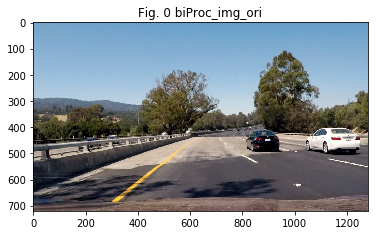

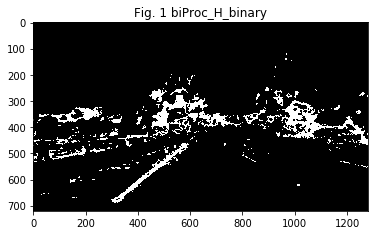

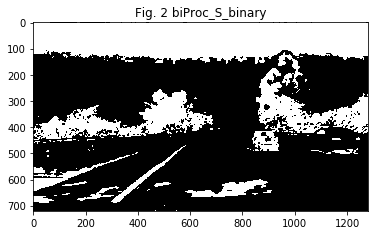

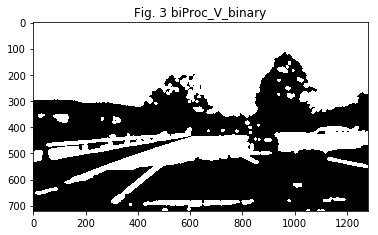

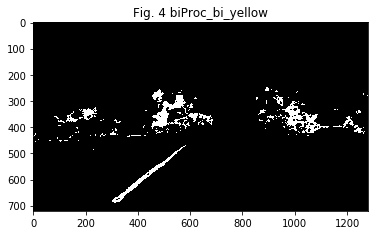

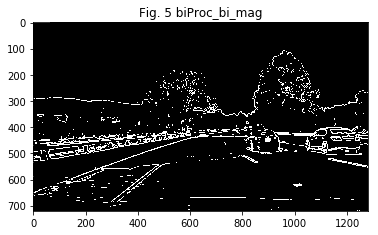

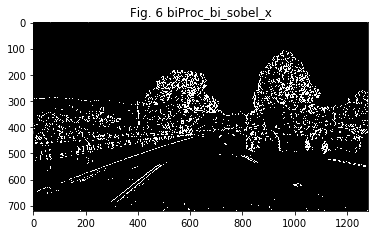

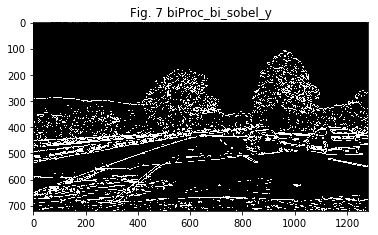

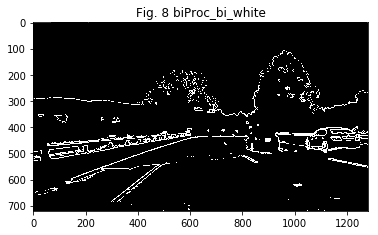

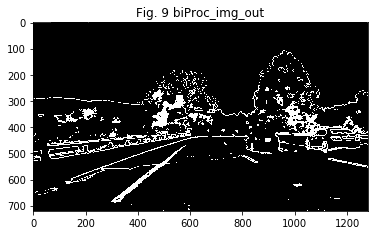

In [9]:
# Test the preprocessing
def function_to_test(img):
    img_out, img_dict = lane_line_mask.pipeline(img, debug=True)
    return img_dict

# Process one image
#-----------#
dir_in = "test_images/"
dir_out = "output_images/lane_line_mask/"
files = sorted(os.listdir(dir_in))
# Read an image
f_name = files[5] # 5
functional_test_of_image(dir_in, f_name, dir_out, function_to_test)

---

### Step 3: Warping Image to "Bird-eye View"

(720, 1280, 3)


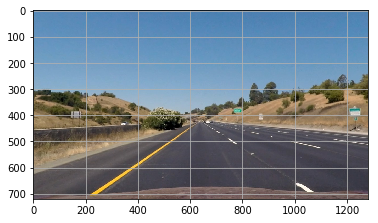

In [10]:
# Draw and save an un-distorted image with grid and poly-lines, so we can find out anchor points by eyes

# Read an image
dir_in = "test_images/"
dir_out = "output_images/warp/"
files = sorted(os.listdir(dir_in))

# Read an image
f_name = files[0] # 0 and 1
img_ori = mpimg.imread(dir_in + f_name) # Read image from disk
img_undistorted = cam_1.undistort(img_ori)
# The shape of image
img_shape = img_undistorted.shape
print(img_shape)

# Ploting
plt.imshow(img_undistorted, cmap='gray')
plt.grid()

# Save the resulted figure
plt.savefig(dir_out + f_name[:-4] + "_grid.png")

In [11]:
class IMAGE_WARPER(object):
    """
    """
    def __init__(self):
        """
        """
        # Parameters
        #-------------------------#
        img_size = (1280, 720) # (width, height)
        # Define 4 source/destination points np.float32([[,],[,],[,],[,]])
        ori_x1 = 200
        ori_x2 = img_size[0] - ori_x1
        self.warp_src = np.float32([ [593,450],[686,450],[ori_x2, img_size[1] ],[ori_x1,img_size[1] ] ])
        tranx_x1 = 300 # 350
        trans_x2 = img_size[0] - tranx_x1
        self.warp_dst = np.float32([[tranx_x1,0],[trans_x2,0],[trans_x2, img_size[1]],[tranx_x1, img_size[1]]])
        print("warp_src = %s" % str(self.warp_src))
        print("warp_dst = %s" % str(self.warp_dst))
        #
        # Define conversions in x and y from pixels space to meters
        lane_width_in_pixel = np.average( [(986 - 293), (1009 - 314), (991 - 304), (1012 - 323)] )
        dash_length_in_pixel = np.average( [(521 - 446), (275 - 200)] )
        self.xm_per_pix = 3.7/lane_width_in_pixel # meters per pixel in x dimension
        self.ym_per_pix = 3.0/dash_length_in_pixel # meters per pixel in y dimension
        print("lane_width_in_pixel = %f" % lane_width_in_pixel)
        print("dash_length_in_pixel = %f" % dash_length_in_pixel)
        test_x = (img_size[0]-2*tranx_x1)
        test_y = img_size[1]
        test_x_m = test_x * self.xm_per_pix
        test_y_m = test_y * self.ym_per_pix
        print("xm_per_pix = %f, %d * xm_per_pix = %f" % (self.xm_per_pix, test_x, test_x_m) )
        print("ym_per_pix = %f, %d * ym_per_pix = %f" % (self.ym_per_pix, test_y, test_y_m) )
        #-------------------------#
        
        # Variables
        #-------------------------#
        self.M_birdeye = None
        self.M_inv_birdeye = None
        #-------------------------#
        
        # Preparation
        self.cal_transform_matrices()
        
    def cal_transform_matrices(self):
        """
        """
        # Calculate the transform matrix
        self.M_birdeye = cv2.getPerspectiveTransform(self.warp_src, self.warp_dst)
        self.M_inv_birdeye = cv2.getPerspectiveTransform(self.warp_dst, self.warp_src)        
        
        
    def transform(self, img, is_interpolating=False):
        """
        """
        img_size = (img.shape[1], img.shape[0])
        if is_interpolating:
            flags = cv2.INTER_LINEAR
        else:
            flags = cv2.INTER_NEAREST
        return cv2.warpPerspective(img, self.M_birdeye, img_size, flags=flags)
    
    def inverse_transform(self, img, is_interpolating=False):
        """
        """
        img_size = (img.shape[1], img.shape[0])
        if is_interpolating:
            flags = cv2.INTER_LINEAR
        else:
            flags = cv2.INTER_NEAREST
        return cv2.warpPerspective(img, self.M_inv_birdeye, img_size, flags=flags)

In [12]:
# Create an instance
birdeye_trans = IMAGE_WARPER()

warp_src = [[  593.   450.]
 [  686.   450.]
 [ 1080.   720.]
 [  200.   720.]]
warp_dst = [[ 300.    0.]
 [ 980.    0.]
 [ 980.  720.]
 [ 300.  720.]]
lane_width_in_pixel = 691.000000
dash_length_in_pixel = 75.000000
xm_per_pix = 0.005355, 680 * xm_per_pix = 3.641100
ym_per_pix = 0.040000, 720 * ym_per_pix = 28.800000


Test the warpping

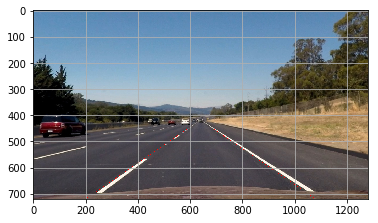

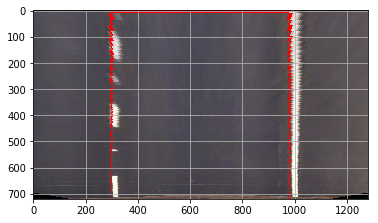

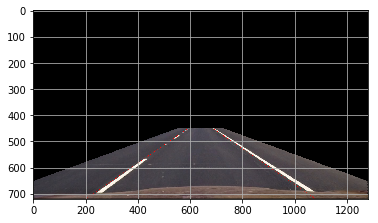

In [13]:
# Read an image
dir_in = "test_images/"
dir_out = "output_images/warp/"
files = sorted(os.listdir(dir_in))

# Read an image
f_name = files[1] # 0 and 1, curve: 2,4,6,7, big curve: 7
img_ori = mpimg.imread(dir_in + f_name) # Read image from disk
img_undistorted = cam_1.undistort(img_ori)

# Draw polygon of source warp region on it
img_line = np.copy(img_undistorted)
cv2.polylines(img_line, np.int32([birdeye_trans.warp_src]), isClosed=True, color=(255, 0, 0), thickness=1)

# Transform the image with line
img_birdeye = birdeye_trans.transform(img_line, is_interpolating=False)

# Inverse transform
img_trans_inverse_transe = birdeye_trans.inverse_transform(img_birdeye, is_interpolating=True)


# Save results
save_image_RGB_or_gray(img_line, dir_out, f_name[:-4] + "_img_line.jpg")
save_image_RGB_or_gray(img_birdeye, dir_out, f_name[:-4] + "_img_birdeye.jpg")
save_image_RGB_or_gray(img_trans_inverse_transe, dir_out, f_name[:-4] + "_img_trans_inverse_transe.jpg")



fig_id = 0
# Ploting
plt.figure(fig_id); fig_id += 1
plt.imshow(img_line, cmap='gray')
plt.grid()
# Save the resulted figure
plt.savefig(dir_out + "plot_" +  f_name[:-4] + "_line.png")

# Ploting
plt.figure(fig_id); fig_id += 1
plt.imshow(img_birdeye, cmap='gray')
plt.grid()
# Save the resulted figure
plt.savefig(dir_out + "plot_" + f_name[:-4] + "_birdeye.png")

# Ploting
plt.figure(fig_id); fig_id += 1
plt.imshow(img_trans_inverse_transe, cmap='gray')
plt.grid()
# Save the resulted figure
plt.savefig(dir_out + "plot_" + f_name[:-4] + "_img_trans_inverse_transe.png")

---

### Integration: Combining all as IMAGE_PREPROCESSING

In [14]:
class IMAGE_PREPROCESSING(object):
    """
    """
    def __init__(self, camera_in, lane_line_mask_in, image_warper_in, prefix="preProc_"):
        """
        """        
        # Variables
        #-------------------------#
        self.camera = camera_in
        self.lane_line_mask = lane_line_mask_in
        self.image_warper = image_warper_in
        self.prefix = prefix
        #-------------------------#
        
    
    def pipeline(self, img_ori, debug=False):
        """
        """
        
        # 1. Undistort the input image
        img_undistorted = self.camera.undistort(img_ori)
        
        # 2. Create binary image marked with lane lines
        img_lane, lane_line_mask_dict = self.lane_line_mask.pipeline(img_undistorted, debug=debug)
        
        # 3. Convert to bird-eye view
        img_birdeye = self.image_warper.transform(img_lane)
        
        # Output image
        img_out = img_birdeye
        
        # Prepare a container for saving intermediate images for debugging
        img_dict = dict()
        if debug:
            # Merge two dictionary
            #-----------------------#
            # img_dict.update(lane_line_mask_dict)
            img_dict = lane_line_mask_dict
            #-----------------------#
            img_dict[self.prefix + "img_ori"] = img_ori
            img_dict[self.prefix + "img_undistorted"] = img_undistorted
            img_dict[self.prefix + "img_lane"] = img_lane
            img_dict[self.prefix + "img_birdeye"] = img_birdeye
            img_dict[self.prefix + "img_out"] = img_out
            
        
        return img_out, img_dict

In [15]:
# Create an instance of IMAGE_PREPROCESSING
img_preproc = IMAGE_PREPROCESSING(cam_1, lane_line_mask, birdeye_trans)

---

Now test the pipeline

In [16]:
sorted(os.listdir("test_images/"))

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

Processing image file test4.jpg
img_dict_key = ['biProc_img_ori', 'biProc_H_binary', 'biProc_S_binary', 'biProc_V_binary', 'biProc_bi_yellow', 'biProc_bi_mag', 'biProc_bi_sobel_x', 'biProc_bi_sobel_y', 'biProc_bi_white', 'biProc_img_out', 'preProc_img_ori', 'preProc_img_undistorted', 'preProc_img_lane', 'preProc_img_birdeye', 'preProc_img_out']


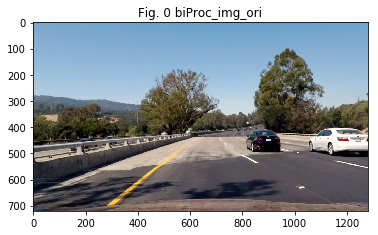

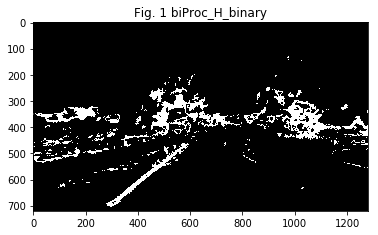

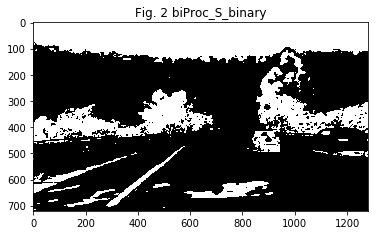

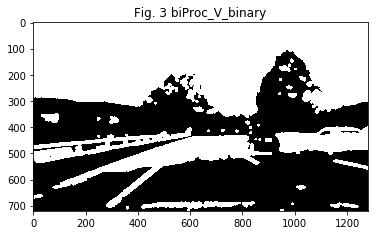

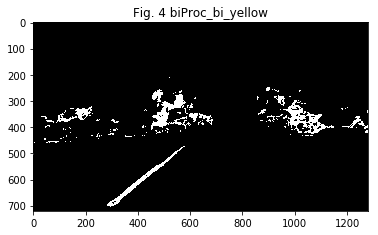

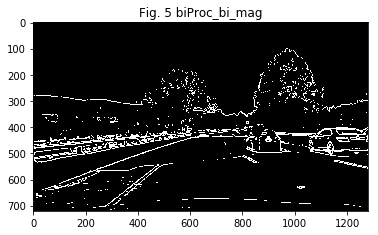

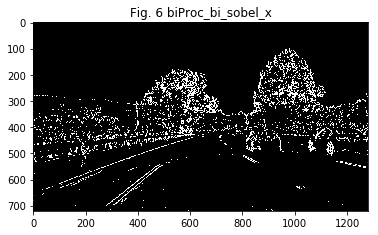

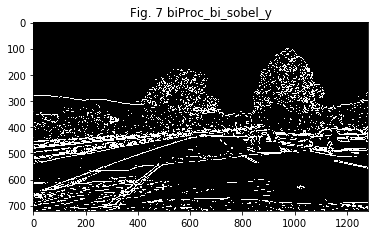

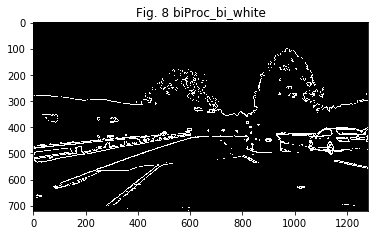

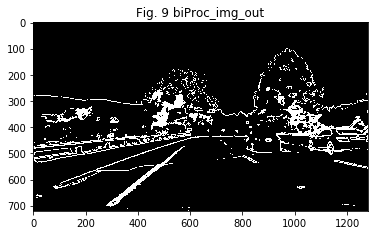

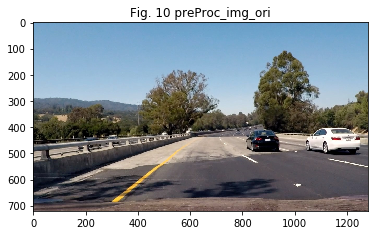

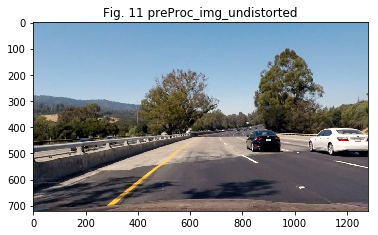

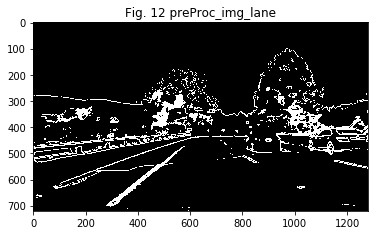

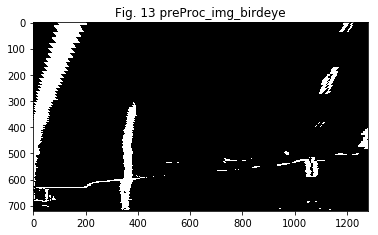

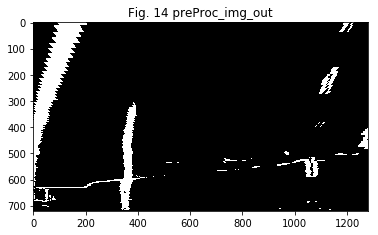

In [17]:
# Test the preprocessing
def function_to_test(img):
    img_out, img_dict = img_preproc.pipeline(img, debug=True)
    return img_dict

# Process one image
#-----------#
dir_in = "test_images/"
dir_out = "output_images/image_preprocessing/"
files = sorted(os.listdir(dir_in))
# Read an image
f_name = files[5] # 5
functional_test_of_image(dir_in, f_name, dir_out, function_to_test)


---

## Lane-finding algorithm

The goal of this process is to locate the lane-lines and fit them to polynomials. By this process, the output will be the curvature of lane and vehicle position repect to center.

- Detect lane pixels and fit to find the lane boundary
- Determine the curvature of the lane and vehicle position with respect to center

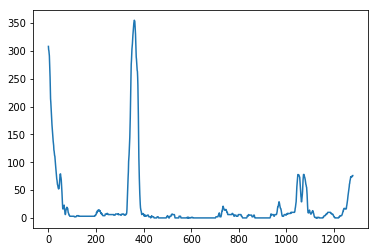

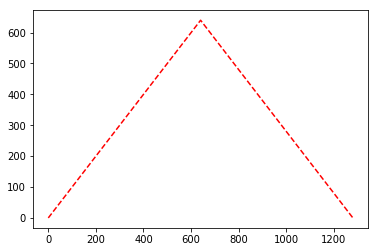

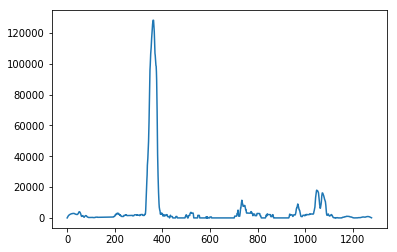

In [18]:
# Test the histogram algorithm
dir_in = "test_images/"
dir_out = "output_images/histogram/"
files = sorted(os.listdir(dir_in))

# Read an image
f_name = files[5] # 0 and 1
img_ori = mpimg.imread(dir_in + f_name) # Read image from disk
img_preProc, _ = img_preproc.pipeline(img_ori, debug=False)

# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img_normalized = img_preProc/255


def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

def weighted_hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    # Weighted hidtogram, more weight at center
    midpoint = np.int(histogram.shape[0]//2)
    histogram_weight = np.array([midpoint - np.abs(midpoint - x) for x in range(len(histogram))] )
    histogram = histogram * histogram_weight
    
    return histogram, histogram_weight

# Create histogram of image binary activations
histogram = hist(img_normalized)
histogram_weighted, histogram_weight = weighted_hist(img_normalized)

# Visualize the resulting histogram
fig_id = 0
# Plotting
plt.figure(fig_id); fig_id += 1
plt.plot(histogram)
# Save the resulted figure
plt.savefig(dir_out + "plot_" + f_name[:-4] + "_histogram.png")

# Plotting
plt.figure(fig_id); fig_id += 1
plt.plot(histogram_weight, "r--")
# Save the resulted figure
plt.savefig(dir_out + "plot_" + f_name[:-4] + "_histogram_weight.png")

# Plotting
plt.figure(fig_id); fig_id += 1
plt.plot(histogram_weighted)
# Save the resulted figure
plt.savefig(dir_out + "plot_" + f_name[:-4] + "_histogram_weighted.png")

In [19]:
class LANE_TRACKER(object):
    """
    """
    def __init__(self, prefix="lane_"):
        """
        """
        # Parameters
        #-------------------------#
        # Sliding window
        self.nwindows = 9 # Choose the number of sliding windows
        self.margin = 100 # 100 # Set the width of the windows +/- margin
        self.minpix = 50 # Set minimum number of pixels found to recenter window
        # Tracking
        self.track_margin = 70 # Set the width of the windows +/- margin
        self.track_minpix = 5000 # Set minimum number of pixels found to window
        #-------------------------#

        # Variables
        #-------------------------#
        self.prefix = prefix
        # Polynominal coefficients, in pixel
        self.left_fit = None
        self.right_fit = None
        # Polynominal coefficients, in meter
        self.left_fit_m = None
        self.right_fit_m = None
        # fitx for ploting
        self.left_fitx = None
        self.right_fitx = None
        #-------------------------#

    # Visualization
    #---------------------------------------------------------------------------------------------------#
    def _get_colored_line_point_image(self, binary_warped, leftx, lefty, rightx, righty, is_drawing_line_only=False):
        """
        """
        # Create an output image to draw on and visualize the result
        if is_drawing_line_only:
            out_img_l = np.zeros_like(binary_warped)
            out_img = np.dstack((out_img_l, out_img_l, out_img_l))
        else:
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        return out_img

    def _draw_strip_inplace(self, out_img, ploty, left_fitx, right_fitx, color=(0, 255, 0)):
        """
        """
        # Draw the lane
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        lane_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        lane_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        lane_pts = np.hstack((lane_window1, lane_window2))
        cv2.fillPoly(out_img, np.int_([lane_pts]), color)

    def _draw_strip(self, out_img, ploty, left_fitx, right_fitx, color=(0, 255, 0)):
        """
        """
        # Draw the lane
        lane_img = np.zeros_like(out_img)
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        lane_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        lane_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        lane_pts = np.hstack((lane_window1, lane_window2))
        cv2.fillPoly(lane_img, np.int_([lane_pts]), color)
        return cv2.addWeighted(out_img, 1, lane_img, 0.5, 0)

    def _draw_polyline_inplace(self, out_img, poly_in, color=(255,0,255), thickness=5):
        """
        """
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        plotx = self.poly_func(poly_in, ploty)
        #
        line_pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
        cv2.polylines(out_img, np.int_([line_pts]), isClosed=False, color=color, thickness=thickness)



    #---------------------------------------------------------------------------------------------------#
    # end Visualization

    def trans_poly_pixel_2_meter(self, poly_in, m_per_pix_out, m_per_pix_in):
        """
        """
        deg = len(poly_in) - 1
        # print("poly_in = %s" % str(poly_in) )
        poly_out =  np.array( [ m_per_pix_out * poly_in[idx]/( m_per_pix_in**(deg-idx) ) for idx in range(len(poly_in))] )
        # print("poly_out = %s" % str(poly_out) )
        return poly_out

    def poly_func(self, poly_in, VAL_in, offset=0):
        """
        NOTE: VAL_in and VAL_out can be array or matrix.
        VAL_out = poly_in[0]*(VAL_in**2) + poly_in[1]*VAL_in + poly_in[2] + offset
        """
        return ( poly_in[0]*(VAL_in**2) + poly_in[1]*VAL_in + poly_in[2] + offset )

    def curvature_func(self, poly_in, VAL_in, is_abs=False):
        """
        NOTE: VAL_in and VAL_out can be array or matrix.
        _R = (1.0 + (2.0*poly_in[0]*VAL_in + poly_in[1])**2)**(1.5)/abs(2.0*poly_in[0])
        """
        if is_abs:
            return ( (1.0 + (2.0*poly_in[0]*VAL_in + poly_in[1])**2)**(1.5)/np.absolute(2.0*poly_in[0]) )
        else:
            return ( (1.0 + (2.0*poly_in[0]*VAL_in + poly_in[1])**2)**(1.5)/(2.0*poly_in[0]) )

    def _fit_poly(self, img_shape, leftx, lefty, rightx, righty):
        ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #
        # Parallelize two curves
        left_fit, right_fit, center_fit = self._parallelize_lines(img_shape, left_fit, right_fit)

        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = self.poly_func(left_fit, ploty)
        right_fitx = self.poly_func(right_fit, ploty)

        return left_fit, right_fit, left_fitx, right_fitx, ploty

    def _parallelize_lines(self, img_shape, left_fit, right_fit):
        # 1. Evaluate the offset of each line regarded to center line
        y_eval = float(img_shape[0] - 1)
        center_fit = (left_fit + right_fit) * 0.5
        lx_center = self.poly_func(center_fit, y_eval)
        lx_left_delta = self.poly_func(left_fit, y_eval, -lx_center)
        lx_right_delta = self.poly_func(right_fit, y_eval, -lx_center)
        # Shift the center_fit
        left_fit = np.copy(center_fit )
        right_fit = np.copy(center_fit )
        left_fit[-1] += lx_left_delta
        right_fit[-1] += lx_right_delta
        return left_fit, right_fit, center_fit

    def _update_poly(self, left_fit, right_fit):
        # Update
        self.left_fit = left_fit
        self.right_fit = right_fit

    def _update_fitx(self, left_fitx, right_fitx):
        # Update
        self.left_fitx = left_fitx
        self.right_fitx = right_fitx

    def _find_lane_pixels(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

        # Weighted hidtogram, more weight at center
        midpoint = np.int(histogram.shape[0]//2)
        histogram_weight = np.array([midpoint - np.abs(midpoint - x) for x in range(len(histogram))] )
        histogram = histogram * histogram_weight

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        endpoint_left = midpoint - 50
        endpoint_right = midpoint + 50
        leftx_base = (endpoint_left-1) - np.argmax(histogram[(endpoint_left-1)::-1]) # Search from the center, the np.argmax() will only return the first found
        rightx_base = np.argmax(histogram[endpoint_right:]) + endpoint_right

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = self.nwindows
        # Set the width of the windows +/- margin
        margin = self.margin
        # Set minimum number of pixels found to recenter window
        minpix = self.minpix

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # The increament of window
        leftx_delta = 0
        rightx_delta = 0

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        win_points_list = []
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - margin  # Update this
            win_xleft_high = leftx_current + margin  # Update this
            win_xright_low = rightx_current - margin  # Update this
            win_xright_high = rightx_current + margin  # Update this

            # Save the window points for ploting
            # Note: (left_rectangle_corner_1, left_rectangle_corner_2, right_rectangle_corner_1, right_rectangle_corner_2)
            win_points_list.append( ( (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (win_xright_low,win_y_low), (win_xright_high,win_y_high)) )

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            ### TO-DO: If you found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            # Left lane-line
            if len(good_left_inds) > minpix:
                leftx_current_new = int(np.mean(nonzerox[good_left_inds]) )
                leftx_delta += 0.2*(leftx_current_new - leftx_current)
                leftx_current = leftx_current_new + int(leftx_delta)
            else:
                leftx_current += int(leftx_delta)
            # Right lane-line
            if len(good_right_inds) > minpix:
                rightx_current_new = int(np.mean(nonzerox[good_right_inds]) )
                rightx_delta += 0.2*(rightx_current_new - rightx_current)
                rightx_current = rightx_current_new + int(rightx_delta)
            else:
                rightx_current += int(rightx_delta)
            # pass # Remove this when you add your function

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, win_points_list # out_img

    def fit_polynomial(self, binary_warped, debug=False, verbose=False):
        # Find our lane pixels first
        leftx, lefty, rightx, righty, win_points_list = self._find_lane_pixels(binary_warped)

        # Fit new polynomials
        left_fit, right_fit, left_fitx, right_fitx, ploty = self._fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        # Update
        self._update_poly(left_fit, right_fit)
        self._update_fitx(left_fitx, right_fitx)

        ## Visualization ##
        #----------------------------#
        # Generate the output image with lane-line pixels marked
        out_img = self._get_colored_line_point_image(binary_warped, leftx, lefty, rightx, righty)
        # Draw the lane
        out_img = self._draw_strip(out_img, ploty, left_fitx, right_fitx)

        if debug:
            # Draw the windows on the visualization image
            for win_points in win_points_list:
                cv2.rectangle(out_img, win_points[0], win_points[1], (128,128,0), 2)
                cv2.rectangle(out_img, win_points[2], win_points[3], (128,128,0), 2)

        # # Plots the left and right polynomials on the lane lines
        self._draw_polyline_inplace(out_img, self.left_fit)
        self._draw_polyline_inplace(out_img, self.right_fit)
        # Draw the center line
        self._draw_polyline_inplace(out_img, (self.left_fit + self.right_fit)*0.5 )

        #----------------------------#
        ## End visualization steps ##

        return out_img

    def search_around_poly(self, binary_warped, debug=False, verbose=False):
        #
        # Save the old fitx for ploting the searching region
        left_fitx_old = self.left_fitx
        right_fitx_old = self.right_fitx
        #
        margin = self.track_margin
        left_fit = self.left_fit
        right_fit = self.right_fit

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > self.poly_func(left_fit, nonzeroy, -margin) )
                          & (nonzerox < self.poly_func(left_fit, nonzeroy, margin)) )
        right_lane_inds = ((nonzerox > self.poly_func(right_fit, nonzeroy, -margin) )
                           & (nonzerox < self.poly_func(right_fit, nonzeroy, margin)) )

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Check if the points in region is not plenty enough
        if len(leftx) < self.track_minpix or len(rightx) < self.track_minpix:
            print("Reset track, len(leftx) = %d, len(rightx) = %d" % (len(leftx), len(rightx)))
            return None

        # Fit new polynomials
        left_fit, right_fit, left_fitx, right_fitx, ploty = self._fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        # Update
        self._update_poly(left_fit, right_fit)
        self._update_fitx(left_fitx, right_fitx)

        ## Visualization ##
        #----------------------------#
        # Generate the output image with lane-line pixels marked
        out_img = self._get_colored_line_point_image(binary_warped, leftx, lefty, rightx, righty)
        # Draw the lane
        out_img = self._draw_strip(out_img, ploty, left_fitx, right_fitx)

        if debug:
            # Draw windows
            window_img = np.zeros_like(out_img)
            self._draw_strip_inplace(window_img, ploty, left_fitx_old-margin, left_fitx_old+margin, color=(128,128,0))
            self._draw_strip_inplace(window_img, ploty, right_fitx_old-margin, right_fitx_old+margin, color=(128,128,0))
            out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # # Plot the polynomial lines onto the image
        self._draw_polyline_inplace(out_img, self.left_fit)
        self._draw_polyline_inplace(out_img, self.right_fit)
        # Draw the center line
        self._draw_polyline_inplace(out_img, (self.left_fit + self.right_fit)*0.5 )
        #----------------------------#
        ## End visualization steps ##

        return out_img

    def find_lane(self, binary_warped, is_fixed_to_sliding_window=False, debug=False):
        """
        """
        is_tracking = False
        if (not is_fixed_to_sliding_window) and ( (not self.left_fit is None) and (not self.right_fit is None) ):
            # print("track")
            out_img = self.search_around_poly(binary_warped, debug=debug)
            if not out_img is None:
                is_tracking = True
                return out_img, is_tracking
        # print("sliding window")
        out_img = self.fit_polynomial(binary_warped, debug=debug)
        return out_img, is_tracking




    def calculate_radius_and_offset(self, binary_warped, xm_per_pix, ym_per_pix, verbose=False):
        # 1. Calculate curvature
        y_eval_m = float(binary_warped.shape[0] - 1) * ym_per_pix
        self.left_fit_m = self.trans_poly_pixel_2_meter( self.left_fit, xm_per_pix, ym_per_pix)
        self.right_fit_m = self.trans_poly_pixel_2_meter( self.right_fit, xm_per_pix, ym_per_pix)
        R_left = self.curvature_func(self.left_fit_m, y_eval_m)
        R_right = self.curvature_func(self.right_fit_m, y_eval_m)
        R_avg = self.curvature_func( (self.left_fit_m + self.right_fit_m )*0.5, y_eval_m)
        R_dict = dict()
        R_dict["R_left"] = R_left
        R_dict["R_right"] = R_right
        R_dict["R_avg"] = R_avg

        # 2. Calculate the vehicle position with respect to center
        x_img_center = float(binary_warped.shape[1] - 1) * xm_per_pix * 0.5
        lx_left = self.poly_func(self.left_fit_m, y_eval_m, -x_img_center)
        lx_right = self.poly_func(self.right_fit_m, y_eval_m, -x_img_center)
        lx_avg = (lx_left + lx_right)*0.5
        lx_delta = lx_right - lx_left
        lx_dict = dict()
        lx_dict["lx_left"] = lx_left
        lx_dict["lx_right"] = lx_right
        lx_dict["lx_avg"] = lx_avg
        lx_dict["lx_delta"] = lx_delta

        if verbose:
            log_out = ""
            log_out += "(R_left, R_right, R_avg) = (%f, %f, %f)" % (R_left, R_right, R_avg)
            log_out += "\n"
            log_out += "(lx_left, lx_right, lx_avg, lx_delta) = (%f, %f, %f, %f)" % (lx_left, lx_right, lx_avg, lx_delta)
            print(log_out)

        return R_dict, lx_dict

    def sanity_check(self, R_dict, lx_dict):
        if lx_dict["lx_delta"] > 4.2 or lx_dict["lx_delta"] < 3.2:
            print("[check] too close")
            return False
        if ( R_dict["R_left"]*R_dict["R_right"] < 0.0) and abs(R_dict["R_left"] - R_dict["R_left"]) > 200.0:
            print("[check] Different direction")
            return False
        if abs(R_dict["R_left"]) < 100.0 or abs(R_dict["R_right"]) < 100.0:
            print("[check] Impossible curvature")
            return False
        return True

    def pipeline(self, binary_warped, xm_per_pix, ym_per_pix, debug=True, verbose=False):
        """
        """
        # 1.Find lane
        out_img, is_tracking = self.find_lane(binary_warped, is_fixed_to_sliding_window=False, debug=debug)
        # 2. Calculate curvature and the vehicle position with respect to center
        R_dict, lx_dict = self.calculate_radius_and_offset(binary_warped, xm_per_pix, ym_per_pix, verbose=verbose)
        # 3. Sanity check
        is_passed = self.sanity_check( R_dict, lx_dict)
        if (not is_passed) and is_tracking:
            print("Reset track")
            # 1. Do it again with sliding window
            out_img, is_tracking = self.find_lane(binary_warped, is_fixed_to_sliding_window=True, debug=debug)
            # 2. Calculate curvature and the vehicle position with respect to center
            R_dict, lx_dict = self.calculate_radius_and_offset(binary_warped, xm_per_pix, ym_per_pix, verbose=verbose)
            # 3. Sanity check
            is_passed = self.sanity_check( R_dict, lx_dict )

        return out_img, R_dict, lx_dict, is_tracking


Create an instance

In [20]:
lane_tracker = LANE_TRACKER()

---

# Full Pipeline

The final step is to integrate all the modules constructed above.

- Image preprocessing
- Lane-finding algorithm
- Visualization


In [21]:
class FULL_PIPELINE(object):
    """
    """
    def __init__(self, img_preproc_in, lane_tracker_in, prefix="full_"):
        """
        """
        # Variables
        #-------------------------#
        self.img_preproc = img_preproc_in
        self.lane_tracker = lane_tracker_in
        self.prefix = prefix
        #-------------------------#
        
    def draw_text_inplace(self, img, text, position, scale=1, color=(255,255,255)):
        """
        """
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = position
        fontScale              = scale # 3
        lineType               = 2
        cv2.putText(img, text, bottomLeftCornerOfText, font, fontScale, color, lineType)
        
    def pipeline(self, img_ori, debug=False, verbose=False, is_birdeye=False):
        """
        """
        # 1. Image preprocessing
        img_birdeye, img_preproc_dict  = self.img_preproc.pipeline(img_ori, debug=debug)
        
        # 2. Lane-finding algorithm
        xm_per_pix = img_preproc.image_warper.xm_per_pix
        ym_per_pix = img_preproc.image_warper.ym_per_pix
        img_lane, R_dict, lx_dict, is_tracking = self.lane_tracker.pipeline(img_birdeye, xm_per_pix, ym_per_pix, debug=debug, verbose=verbose)
        
        # 3. Visualization  
        if is_birdeye:
            img_lane_unwarp = img_lane
            img_birdeye_color = img_preproc.image_warper.transform(img_ori, is_interpolating=True)
            img_mix = cv2.addWeighted(img_birdeye_color, 1, img_lane, 0.8, 0)
        else: # default
            img_lane_unwarp = img_preproc.image_warper.inverse_transform(img_lane, is_interpolating=True)
            img_mix = cv2.addWeighted(img_ori, 1, img_lane_unwarp, 0.8, 0)
        
        # Output image
        img_out = img_mix
        
#         text = "(L,R,C)=(%.0f, %.0f, %.0f)" % (R_dict["R_left"], R_dict["R_right"], R_dict["R_avg"])
        text = "Turning %s, radius = %.0fm" % ("right" if R_dict["R_avg"] > 0.0 else "left", abs(R_dict["R_avg"]) )
        self.draw_text_inplace(img_out, text, (70,60), scale=2 )
        text = "Vehicle is %.2fm %s of center" % (abs(lx_dict["lx_avg"]), "left" if lx_dict["lx_avg"] >=0 else "right" )
        self.draw_text_inplace(img_out, text, (70,120), scale=2 )
        
        # Prepare a container for saving intermediate images for debugging
        img_dict = dict()
        if debug:
            # Merge two dictionary
            #-----------------------#
            # img_dict.update(lane_line_mask_dict)
            img_dict = img_preproc_dict
            #-----------------------#
            img_dict[self.prefix + "img_ori"] = img_ori
            img_dict[self.prefix + "img_birdeye"] = img_birdeye
            if is_tracking:
                img_dict[self.prefix + "img_lane_track"] = img_lane
                img_dict[self.prefix + "img_lane_unwarp_track"] = img_lane_unwarp
                img_dict[self.prefix + "img_out_track"] = img_out
            else:
                img_dict[self.prefix + "img_lane_sliding"] = img_lane
                img_dict[self.prefix + "img_lane_unwarp_sliding"] = img_lane_unwarp
                img_dict[self.prefix + "img_out_sliding"] = img_out
            
        return img_out, img_dict 
        

Create an Instance

In [22]:
full_pipe = FULL_PIPELINE(img_preproc, lane_tracker)

---

Now test the pipeline 

Processing image file test4.jpg
(R_left, R_right, R_avg) = (606.284048, 606.284048, 606.284048)
(lx_left, lx_right, lx_avg, lx_delta) = (-1.552734, 2.190485, 0.318876, 3.743219)
img_dict_key = ['biProc_img_ori', 'biProc_H_binary', 'biProc_S_binary', 'biProc_V_binary', 'biProc_bi_yellow', 'biProc_bi_mag', 'biProc_bi_sobel_x', 'biProc_bi_sobel_y', 'biProc_bi_white', 'biProc_img_out', 'preProc_img_ori', 'preProc_img_undistorted', 'preProc_img_lane', 'preProc_img_birdeye', 'preProc_img_out', 'full_img_ori', 'full_img_birdeye', 'full_img_lane_sliding', 'full_img_lane_unwarp_sliding', 'full_img_out_sliding']


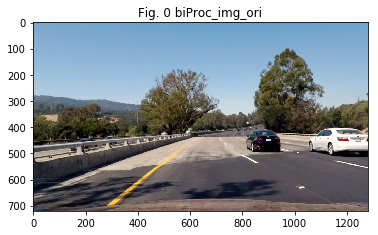

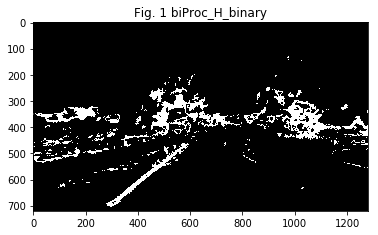

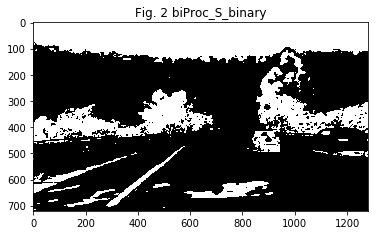

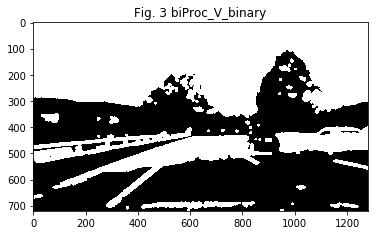

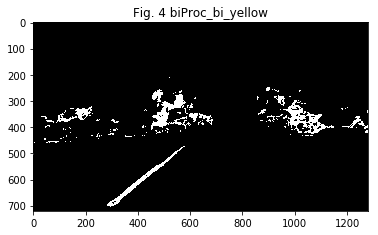

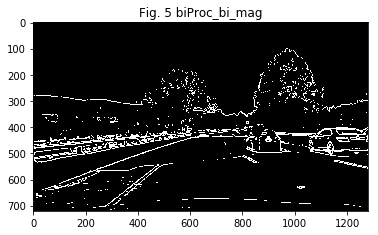

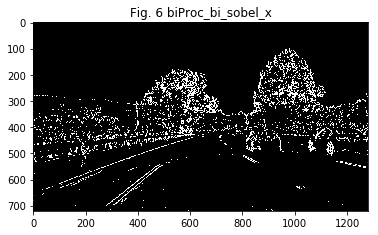

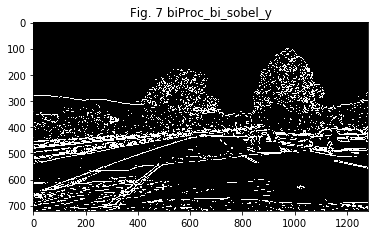

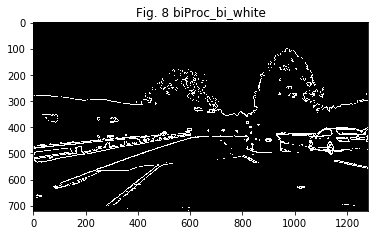

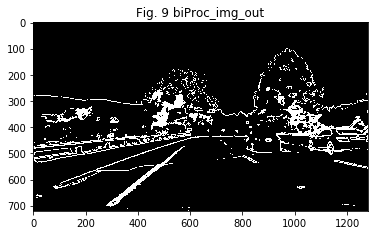

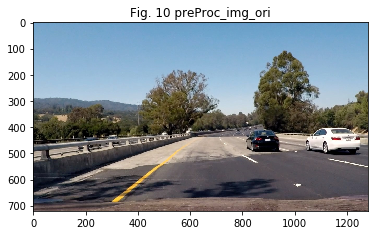

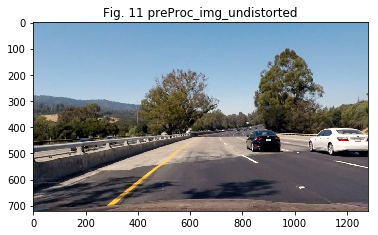

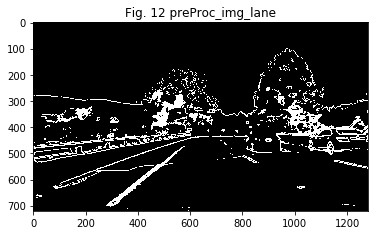

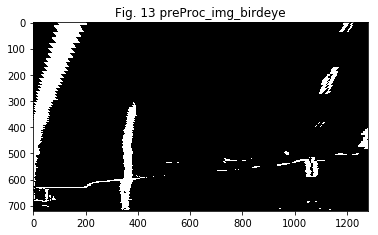

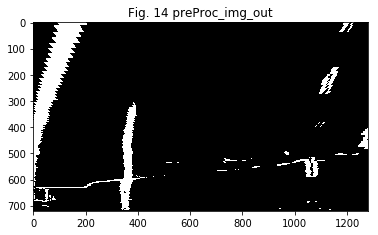

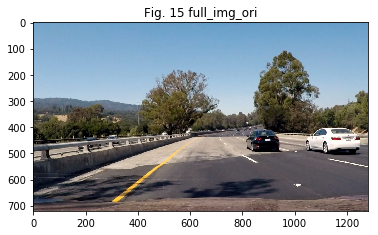

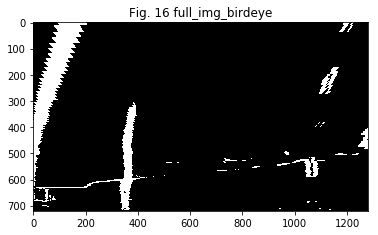

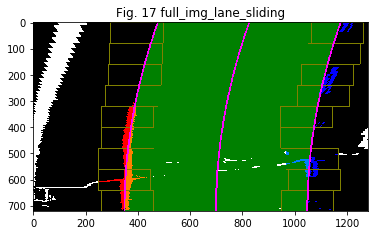

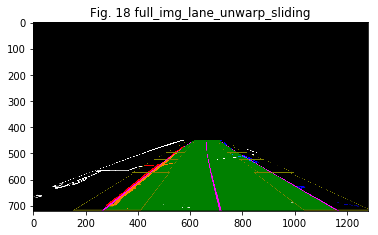

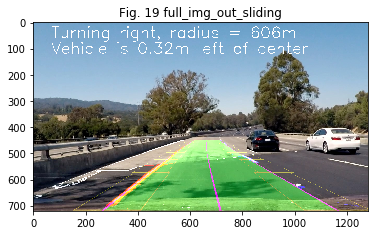

In [23]:
# Test the preprocessing
def function_to_test(img):
    img_out, img_dict = full_pipe.pipeline(img, debug=True, verbose=True)
    return img_dict

# Process one image
#-----------#
dir_in = "test_images/"
dir_out = "output_images/full_pipeline/step/"
files = sorted(os.listdir(dir_in))
# Read an image
f_name = files[5] # 3 5
functional_test_of_image(dir_in, f_name, dir_out, function_to_test)

In [24]:
# Process all images in the directory
#-----------#
dir_in = "test_images/"
dir_out = "output_images/full_pipeline/"
files = sorted(os.listdir(dir_in))
for f_name in files:
    print("Processing image file %s" % f_name)
    img_ori = mpimg.imread(dir_in + f_name)
    img_proc, img_dict = full_pipe.pipeline(img_ori, debug=False)
    # Saving images using cv2.imwrite(), which require BGR color layout rather than RGB
    cv2.imwrite(dir_out + f_name, cv2.cvtColor(img_proc, cv2.COLOR_RGB2BGR))

Processing image file straight_lines1.jpg
Reset track, len(leftx) = 19320, len(rightx) = 2435
Processing image file straight_lines2.jpg
Processing image file test1.jpg
Reset track, len(leftx) = 12024, len(rightx) = 2069
Processing image file test2.jpg
Reset track, len(leftx) = 17088, len(rightx) = 4351
Processing image file test3.jpg
Processing image file test4.jpg
Processing image file test5.jpg
Processing image file test6.jpg


---

# Test on Videos

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
def process_image(image):
    img_out, _ = full_pipe.pipeline(image, debug=True)
    return img_out

In [27]:
video_name = "project_video.mp4"
# video_name = "challenge_video.mp4"
# video_name = "harder_challenge_video.mp4"

In [ ]:
white_output = 'output_videos/' + video_name
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip(video_name).subclip(0,5)
# clip1 = VideoFileClip(video_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


 86%|████████▌ | 108/126 [00:25<00:04,  3.79it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
# !tar chvfz notebook.tar.gz *

In [ ]:
# !tar chvfz output_images.tar.gz ./output_images

In [ ]:
# !tar chvfz output_videos.tar.gz ./output_videos